In [12]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import pickle
from omegaconf import DictConfig, OmegaConf
import optuna.visualization as vis
import plotly
import optuna

In [13]:
# 将 MScProject 目录添加到 Python 模块搜索路径
sys.path.append(os.path.abspath('..'))
# 从 DataGenerate.py 导入 DataGenerate 类 用于pickle导入
from DataGenerate import TrainValidManage


In [16]:
# 加载 config.yaml 文件
main_config = OmegaConf.load("config/config.yaml")

# 打印完整的配置内容
print(OmegaConf.to_yaml(main_config))

base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
data_generation:
  load_data:
    node_mean: 50.0
    node_var: 10.0
    node_iid_var: 5.0
    node_theta: 0.9
  latency:
    mean: 0.0
    var: 0.0
    iid_var: 0.0
    theta: 0.0
exp4:
  batch_size: 64
  seq_length: 20
  input_size: 10
  output_size: 10
  learning_rate: 0.001
  num_workers: 24
  num_epochs: 100
  device: cuda
  mix_precision: true
  patience_epochs: 6
  min_delta: 0.001
  mode: min
  factor: 0.1
  patience_lr: 2
  min_lr: 1.0e-06
  threshold: 0.01
  ARconfig:
    order: 5
  LSTMconfig:
    hidden_size: 128
    num_layers: 4
    dropout_prob: 0.2
    weight_decay: 0.0001
  GNNconfig:
    hidden_size: 128
    num_layers: 4



In [17]:
# # 明确添加安全的全局对象, 用于防止导入pickle时的警告信息
# torch.serialization.add_safe_globals({"TrainValidManage": TrainValidManage})

# 从文件加载对象
with open('Data/ar1_data_train_val_manage.pkl', 'rb') as f:
    ar1_data_train_val_manage = pickle.load(f)
    
# 从文件加载对象
with open('Data/iid_data_train_val_manage.pkl', 'rb') as f:
    iid_data_train_val_manage = pickle.load(f)

/usr/local/Anaconda3/envs/MScProject/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


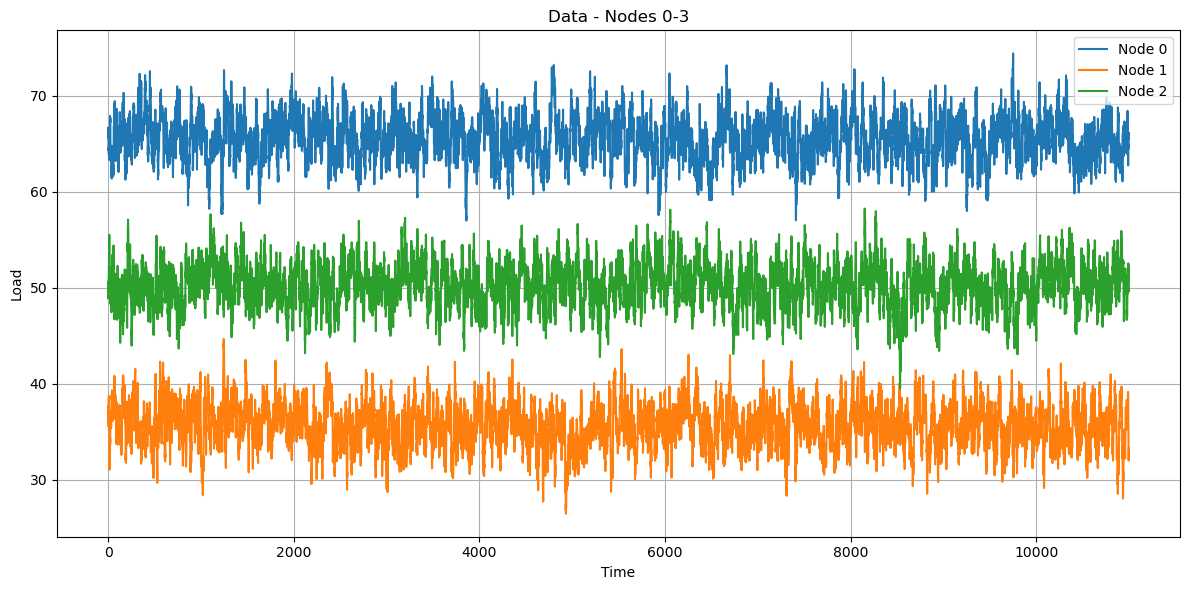

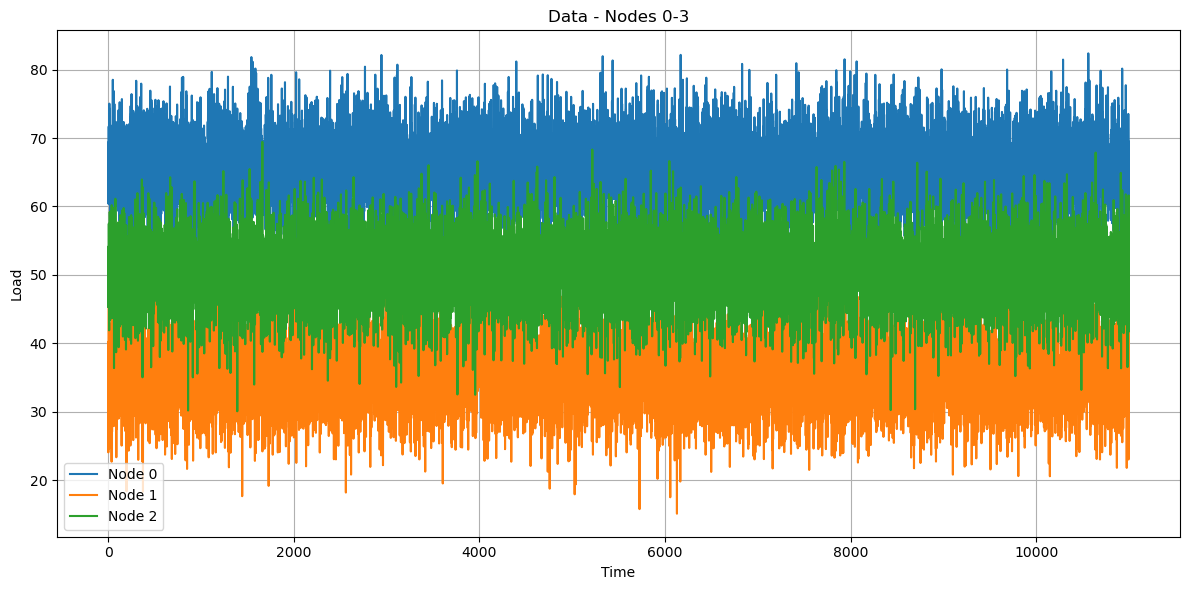

In [18]:
ar1_data_train_val_manage.plot_range_data(ar1_data_train_val_manage.data_np[:3, :], title='Data')
iid_data_train_val_manage.plot_range_data(iid_data_train_val_manage.data_np[:3, :], title='Data')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import re
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.stats import norm

In [ ]:
def plot_combined(data, title):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    time = np.arange(data.shape[1])

    # Plot distributions (left subplot)
    for i in range(data.shape[0]):
        mean = np.mean(data[i])
        std = np.std(data[i])
        x = np.linspace(mean - 3 * std, mean + 3 * std, 100)
        p = norm.pdf(x, mean, std)
        axs[0].plot(x, p, label=f'Node {i + 1}')
    axs[0].set_title(f'{title} - Distribution')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Density')
    axs[0].legend()
    axs[0].grid(True)

    def exponential_moving_average(data, alpha):
        ema = np.zeros_like(data)
        ema[0] = data[0]
        for t in range(1, len(data)):
            ema[t] = alpha * data[t] + (1 - alpha) * ema[t - 1]
        return ema

    # Plot smoothed time series (right subplot)
    for i in range(data.shape[0]):
        smoothed_data = savgol_filter(data[i], window_length=51, polyorder=3)
        axs[1].plot(time, smoothed_data, label=f'Node {i + 1}')
    axs[1].set_title(f'{title} - Time Series')
    axs[1].set_xlabel('Time (T)')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    fig.savefig(f'image/{title}.png')
    plt.show()

In [2]:
# # Function to generate random means
# def generate_means(N, mean_load, var_load, mean_latency, var_latency):
#     print('Mean Load:', mean_load)
#     print('Variance Load:', var_load)
#     print('Mean Latency:', mean_latency)
#     print('Variance Latency:', var_latency)
#     means_load = np.random.normal(loc=mean_load, scale=np.sqrt(var_load), size=N)
#     means_latency = np.random.normal(loc=mean_latency, scale=np.sqrt(var_latency), size=N)
# 
#     # Create figure and subplots
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# 
#     # Plotting means_load
#     ax1.plot(means_load, marker='o', linestyle='-', color='b', label='means_load')
#     ax1.set_title('Random Means for Load')
#     ax1.set_xlabel('Node')
#     ax1.set_ylabel('Mean Load')
#     ax1.legend()
#     ax1.grid(True)
# 
#     # Plotting means_latency
#     ax2.plot(means_latency, marker='o', linestyle='-', color='r', label='means_latency')
#     ax2.set_title('Random Means for Latency')
#     ax2.set_xlabel('Node')
#     ax2.set_ylabel('Mean Latency')
#     ax2.legend()
#     ax2.grid(True)
# 
#     # Adjust layout
#     plt.tight_layout()
#     plt.show()
# 
#     return means_load, means_latency

In [3]:
# # Function to generate AR(1) data
# def generate_ar1_data(N, T, means_load, means_latency, theta):
#     print('Theta:', theta)
#     load = np.zeros((N, T))
#     ar1_latency = np.zeros((N, T))
#     ar1_standardized_latency = np.zeros((N, T))
#     uniform_latency = np.zeros((N, T))
#     latency = np.zeros((N, T))
# 
#     def generate_ar1(theta, n, mean_node):
#         ar1 = np.zeros(n)
#         ar1[0] = mean_node
#         for t in range(1, n):
#             ar1[t] = ar1[t - 1] + (1 - theta) * (mean_node - ar1[t - 1]) + np.random.normal(0, 1)
#         return ar1
# 
#     for i in range(N):
#         load[i] = generate_ar1(theta, T, means_load[i])
#         ar1_latency[i] = generate_ar1(theta, T, means_latency[i])
#         ar1_standardized_latency[i] = (ar1_latency[i] - np.mean(ar1_latency[i])) / np.std(ar1_latency[i])
#         uniform_latency[i] = norm.cdf(ar1_standardized_latency[i])
#         lambda_param = 1
#         latency[i] = -np.log(1 - uniform_latency[i]) / lambda_param
# 
#     return load, latency

In [4]:
# # Function to generate IID data
# def generate_iid_data(N, T, means_load, means_latency):
#     rates_latency = means_latency
# 
#     load = np.zeros((N, T))
#     latency = np.zeros((N, T))
# 
#     for i in range(N):
#         load[i] = np.random.normal(loc=means_load[i], scale=1, size=T)
#         latency[i] = np.random.exponential(scale=1.0/rates_latency[i], size=T)
# 
#     return load, latency

In [5]:
def epsilon_greedy_algorithm(load, latency, epsilons, alpha=1.0):
    def epsilon_greedy(epsilon, rewards, estimated_means):
        if np.random.rand() < epsilon:
            return np.random.randint(len(rewards))
        else:
            return np.argmax(estimated_means)

    def calculate_regret(true_means, chosen_means):
        mu_star = np.max(true_means)
        regret = mu_star - chosen_means
        return regret

    results = {}
    for epsilon in epsilons:
        rewards_load = 1 / (1 + load)
        rewards_latency = np.exp(-alpha * latency)

        estimated_means_load = np.zeros(N)
        estimated_means_latency = np.zeros(N)
        chosen_counts_load = np.zeros(N)
        chosen_counts_latency = np.zeros(N)

        cumulative_regret_load = np.zeros(T)
        cumulative_regret_latency = np.zeros(T)
        single_step_regret_load = np.zeros(T)
        single_step_regret_latency = np.zeros(T)

        for t in range(T):
            chosen_node_load = epsilon_greedy(epsilon, rewards_load[:, t], estimated_means_load)
            chosen_node_latency = epsilon_greedy(epsilon, rewards_latency[:, t], estimated_means_latency)

            reward_load = rewards_load[chosen_node_load, t]
            reward_latency = rewards_latency[chosen_node_latency, t]

            chosen_counts_load[chosen_node_load] += 1
            chosen_counts_latency[chosen_node_latency] += 1

            estimated_means_load[chosen_node_load] += (reward_load - estimated_means_load[chosen_node_load]) / chosen_counts_load[chosen_node_load]
            estimated_means_latency[chosen_node_latency] += (reward_latency - estimated_means_latency[chosen_node_latency]) / chosen_counts_latency[chosen_node_latency]

            single_step_regret_load[t] = calculate_regret(np.mean(rewards_load, axis=1), estimated_means_load[chosen_node_load])
            single_step_regret_latency[t] = calculate_regret(np.mean(rewards_latency, axis=1), estimated_means_latency[chosen_node_latency])

            if t == 0:
                cumulative_regret_load[t] = single_step_regret_load[t]
                cumulative_regret_latency[t] = single_step_regret_latency[t]
            else:
                cumulative_regret_load[t] = cumulative_regret_load[t - 1] + single_step_regret_load[t]
                cumulative_regret_latency[t] = cumulative_regret_latency[t - 1] + single_step_regret_latency[t]

        results[epsilon] = {
            'single_step_regret_load': single_step_regret_load,
            'cumulative_regret_load': cumulative_regret_load,
            'single_step_regret_latency': single_step_regret_latency,
            'cumulative_regret_latency': cumulative_regret_latency
        }

    return results

In [6]:
def plot_combined_results(load, latency, results, epsilons, tittle = 'Performance Metrics over Time', smoothing_window=50):
    fig, axs = plt.subplots(2, 3, figsize=(18, 9))

    # Adding overall title
    fig.suptitle(tittle, fontsize=16)

    # Plotting load data
    for i in range(load.shape[0]):
        axs[0, 0].plot(load[i], label=f'Node {i + 1}')
    axs[0, 0].set_title('Load over Time')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('Load')
    axs[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plotting latency data
    for i in range(latency.shape[0]):
        axs[1, 0].plot(latency[i], label=f'Node {i + 1}')
    axs[1, 0].set_title('Latency over Time')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Latency')
    axs[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Single Step Regret for Load
    for epsilon in epsilons:
        smoothed_data = uniform_filter1d(results[epsilon]['single_step_regret_load'], size=smoothing_window)
        axs[0, 1].plot(smoothed_data, label=f'epsilon={epsilon}')
        # axs[0, 1].plot(results[epsilon]['single_step_regret_load'], label=f'epsilon={epsilon}')
    axs[0, 1].set_title('Single Step Regret for Load')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('Regret')
    axs[0, 1].legend()

    # Single Step Regret for Latency
    for epsilon in epsilons:
        smoothed_data = uniform_filter1d(results[epsilon]['single_step_regret_latency'], size=smoothing_window)
        axs[1, 1].plot(smoothed_data, label=f'epsilon={epsilon}')
        # axs[1, 1].plot(results[epsilon]['single_step_regret_latency'], label=f'epsilon={epsilon}')
    axs[1, 1].set_title('Single Step Regret for Latency')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Regret')
    axs[1, 1].legend()

    # Cumulative Regret for Load
    for epsilon in epsilons:
        axs[0, 2].plot(results[epsilon]['cumulative_regret_load'], label=f'epsilon={epsilon}')
    axs[0, 2].set_title('Cumulative Regret for Load')
    axs[0, 2].set_xlabel('Time')
    axs[0, 2].set_ylabel('Cumulative Regret')
    axs[0, 2].legend()

    # Cumulative Regret for Latency
    for epsilon in epsilons:
        axs[1, 2].plot(results[epsilon]['cumulative_regret_latency'], label=f'epsilon={epsilon}')
    axs[1, 2].set_title('Cumulative Regret for Latency')
    axs[1, 2].set_xlabel('Time')
    axs[1, 2].set_ylabel('Cumulative Regret')
    axs[1, 2].legend()

    plt.tight_layout()

    # Create 'Results' directory if it doesn't exist
    if not os.path.exists('Results'):
        os.makedirs('Results')

    # Sanitize the title for use as a filename
    sanitized_title = sanitize_filename(tittle)

    # Save the figure to the 'Results' directory
    plt.savefig(f'Results/{sanitized_title}.png')

    plt.show()

In [7]:
def sanitize_filename(filename):
    # Remove or replace invalid characters
    return re.sub(r'[<>:"/\\|?*;]', '_', filename)

Mean Load: 15
Variance Load: 5
Mean Latency: 10
Variance Latency: 2


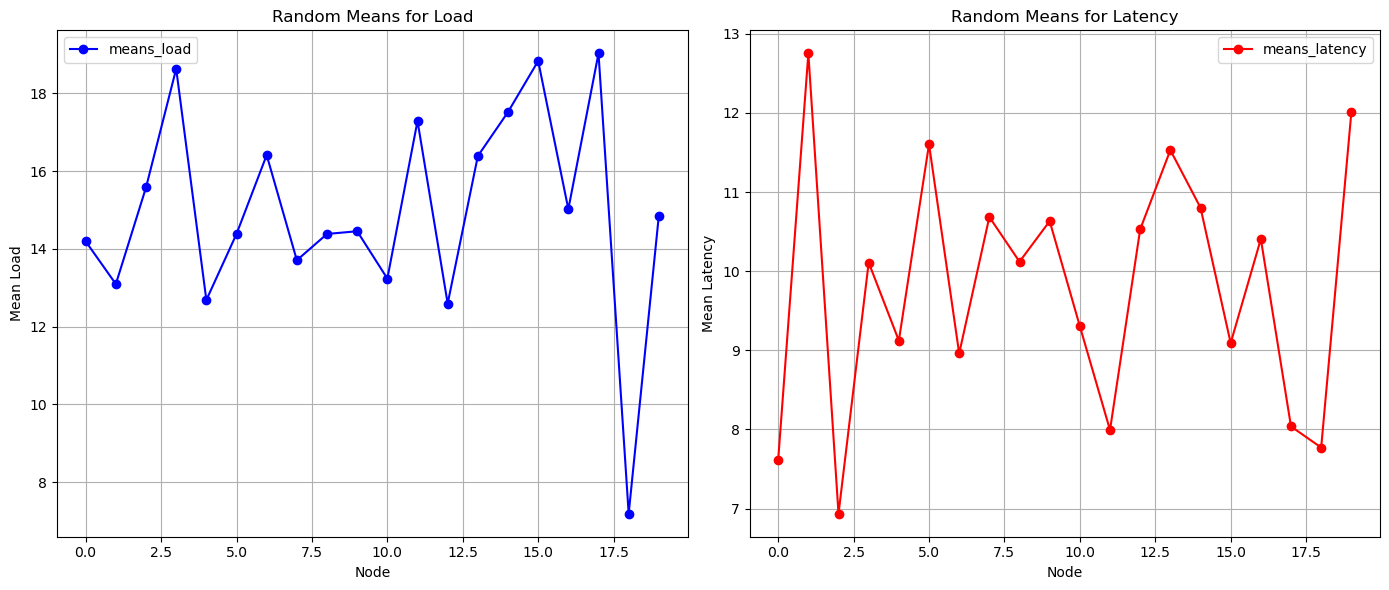

Theta: 0.5


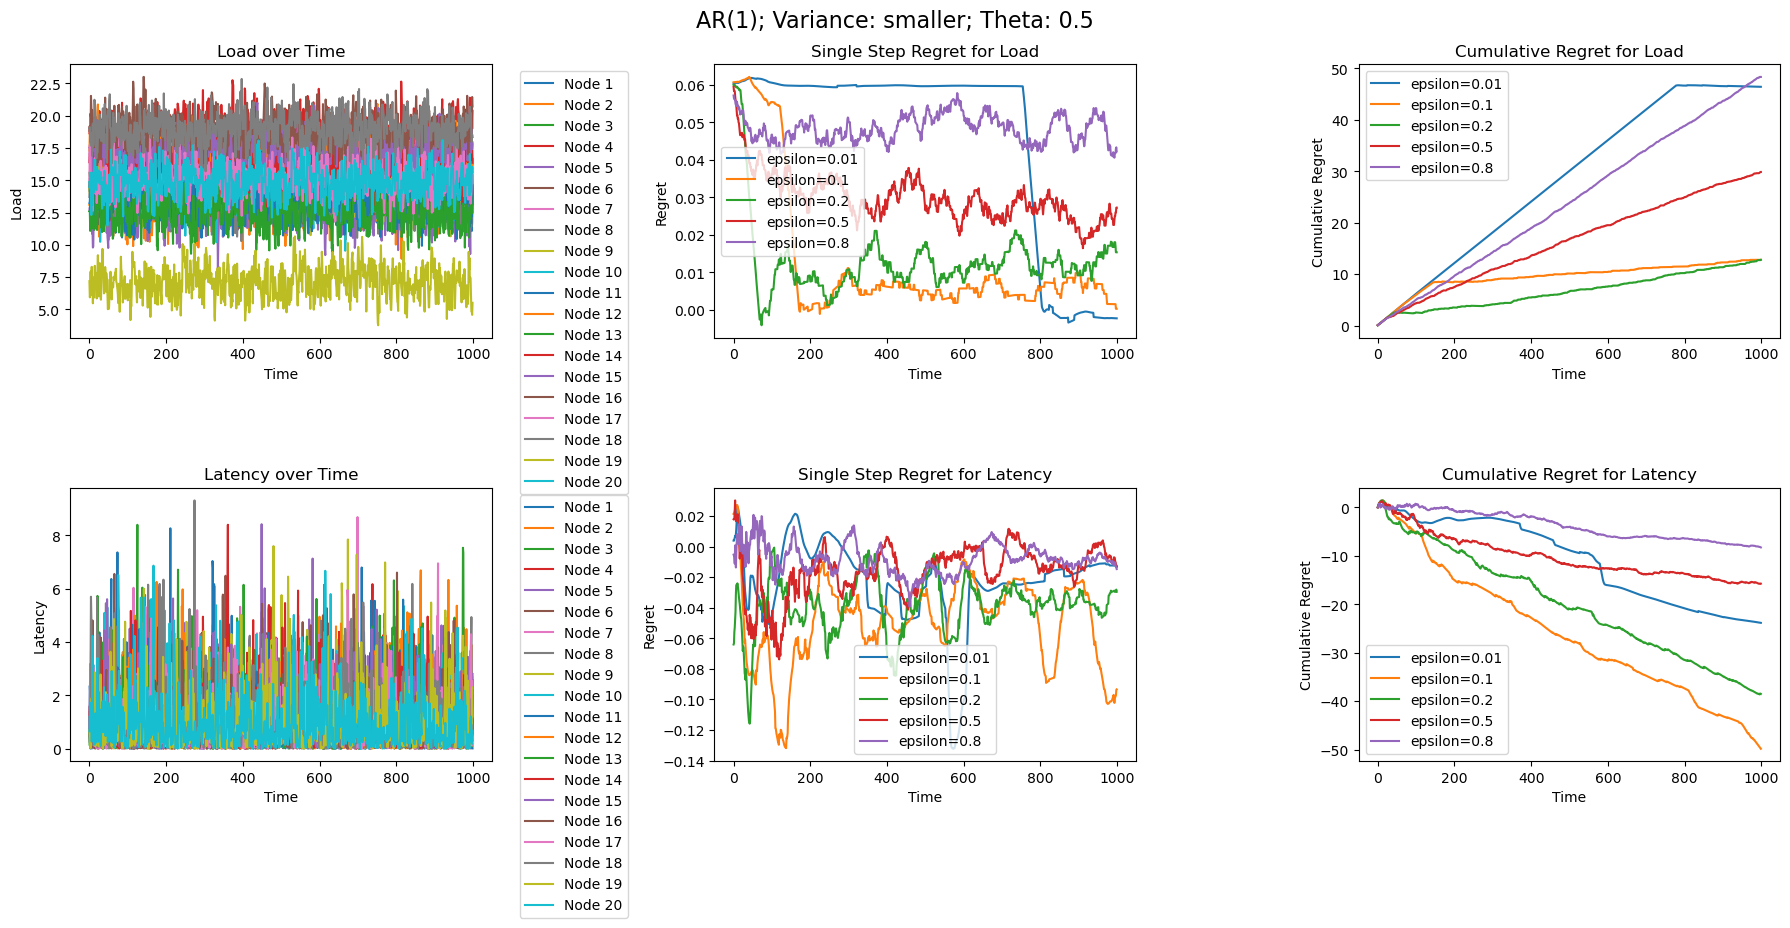

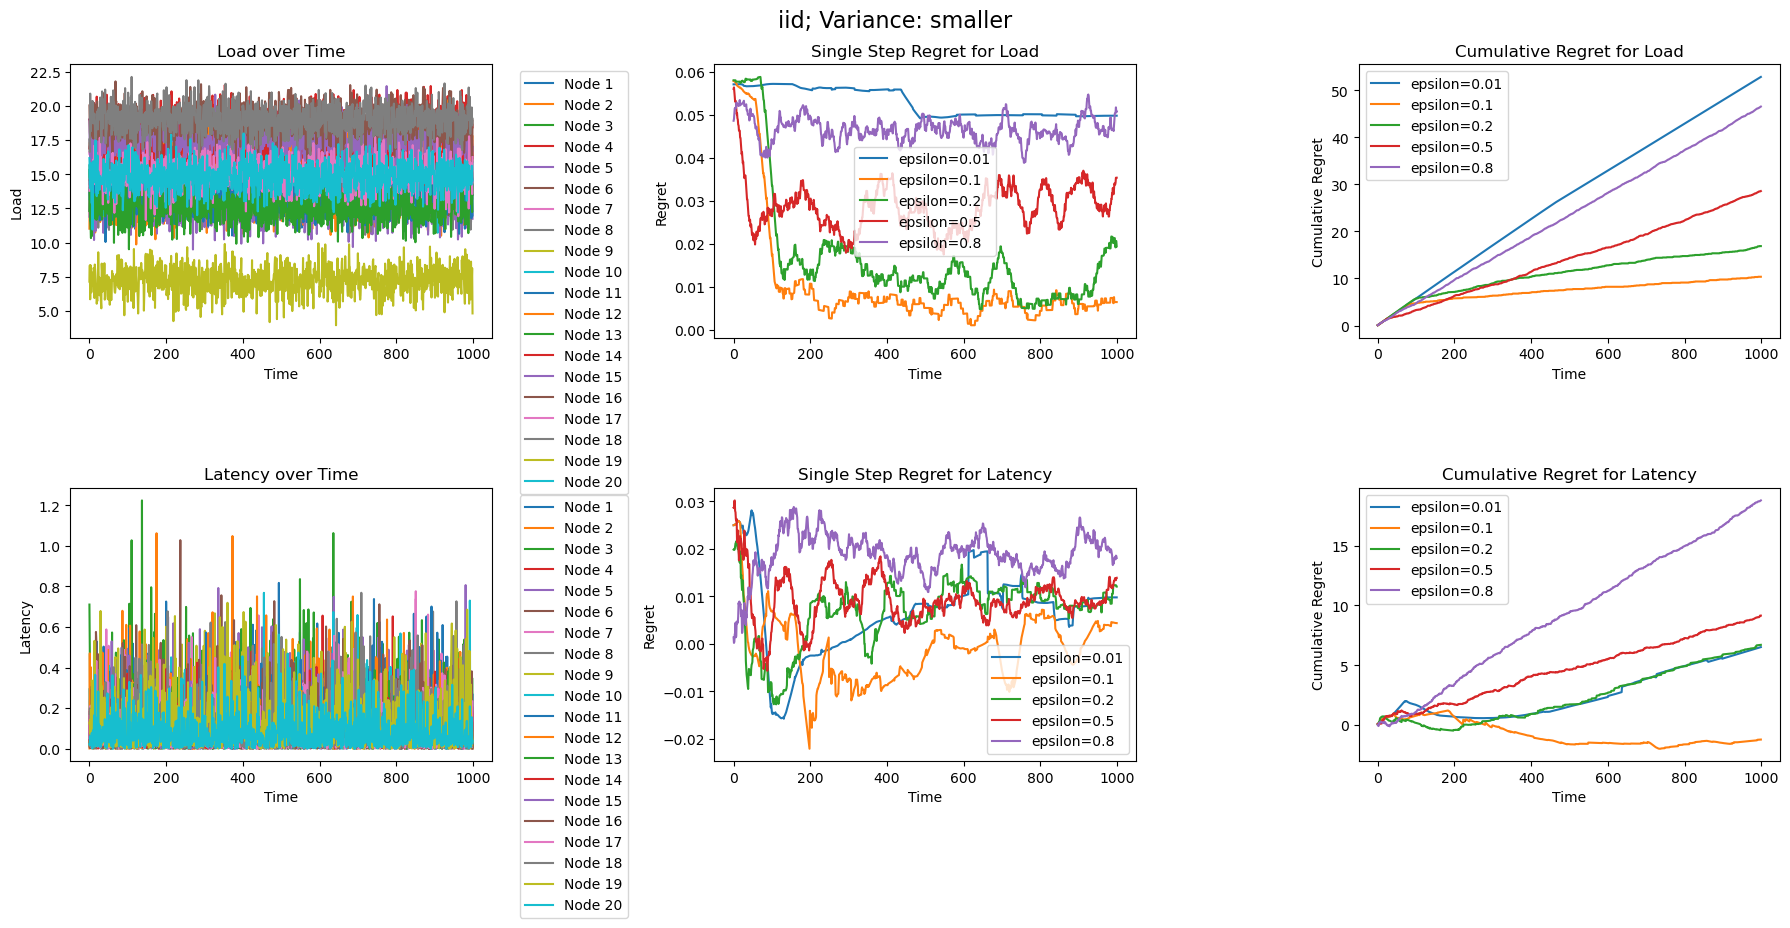

In [8]:
N = 20
T = 1000
mean_load = 15
var_load = 5
mean_latency = 10
var_latency = 2
theta = 0.5
epsilons = [0.01, 0.1, 0.2, 0.5, 0.8]

means_load, means_latency = generate_means(N, mean_load, var_load, mean_latency, var_latency)

load_ar1, latency_ar1 = generate_ar1_data(N, T, means_load, means_latency, theta)
results_ar1 = epsilon_greedy_algorithm(load_ar1, latency_ar1, epsilons)
plot_combined_results(load_ar1, latency_ar1, results_ar1, epsilons, 'AR(1); Variance: smaller; Theta: 0.5')

load_iid, latency_iid = generate_iid_data(N, T, means_load, means_latency)
results_iid = epsilon_greedy_algorithm(load_iid, latency_iid, epsilons)
plot_combined_results(load_iid, latency_iid, results_iid, epsilons, 'iid; Variance: smaller')

In [9]:
N = 20
T = 1000
mean_load = 15
var_load = 10
mean_latency = 10
var_latency = 5
theta = 0.5
epsilons = [0.01, 0.1, 0.2, 0.5, 0.8]

Mean Load: 15
Variance Load: 10
Mean Latency: 10
Variance Latency: 5


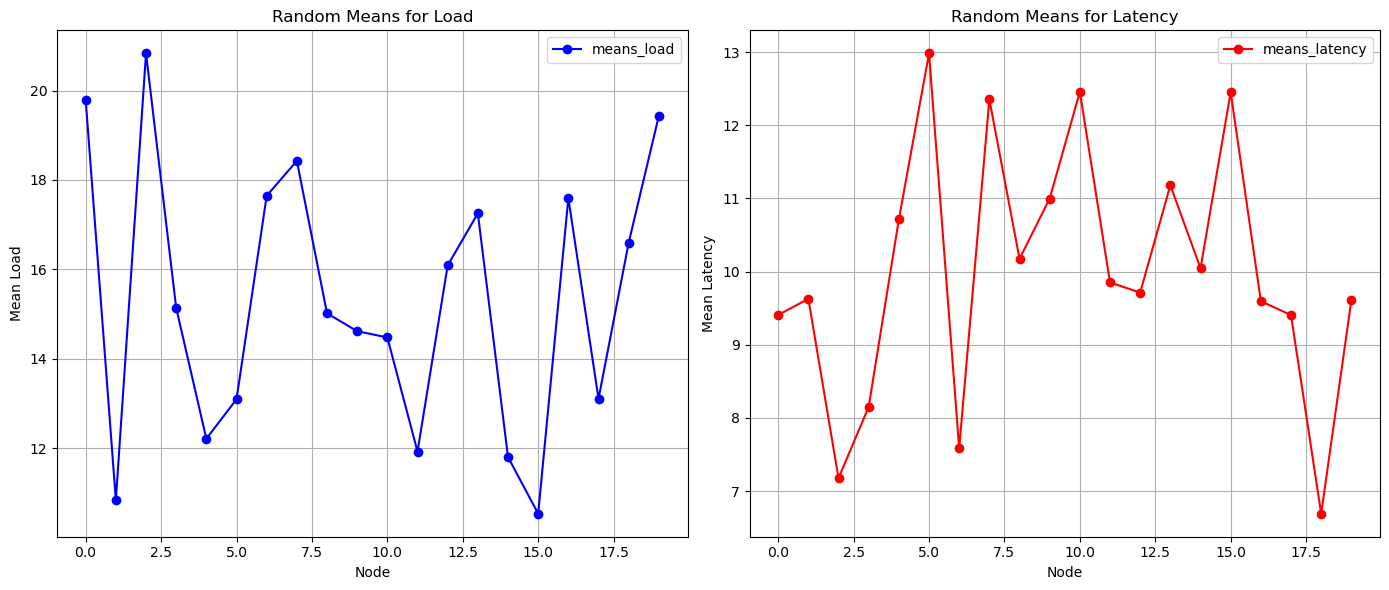

Theta: 0.5


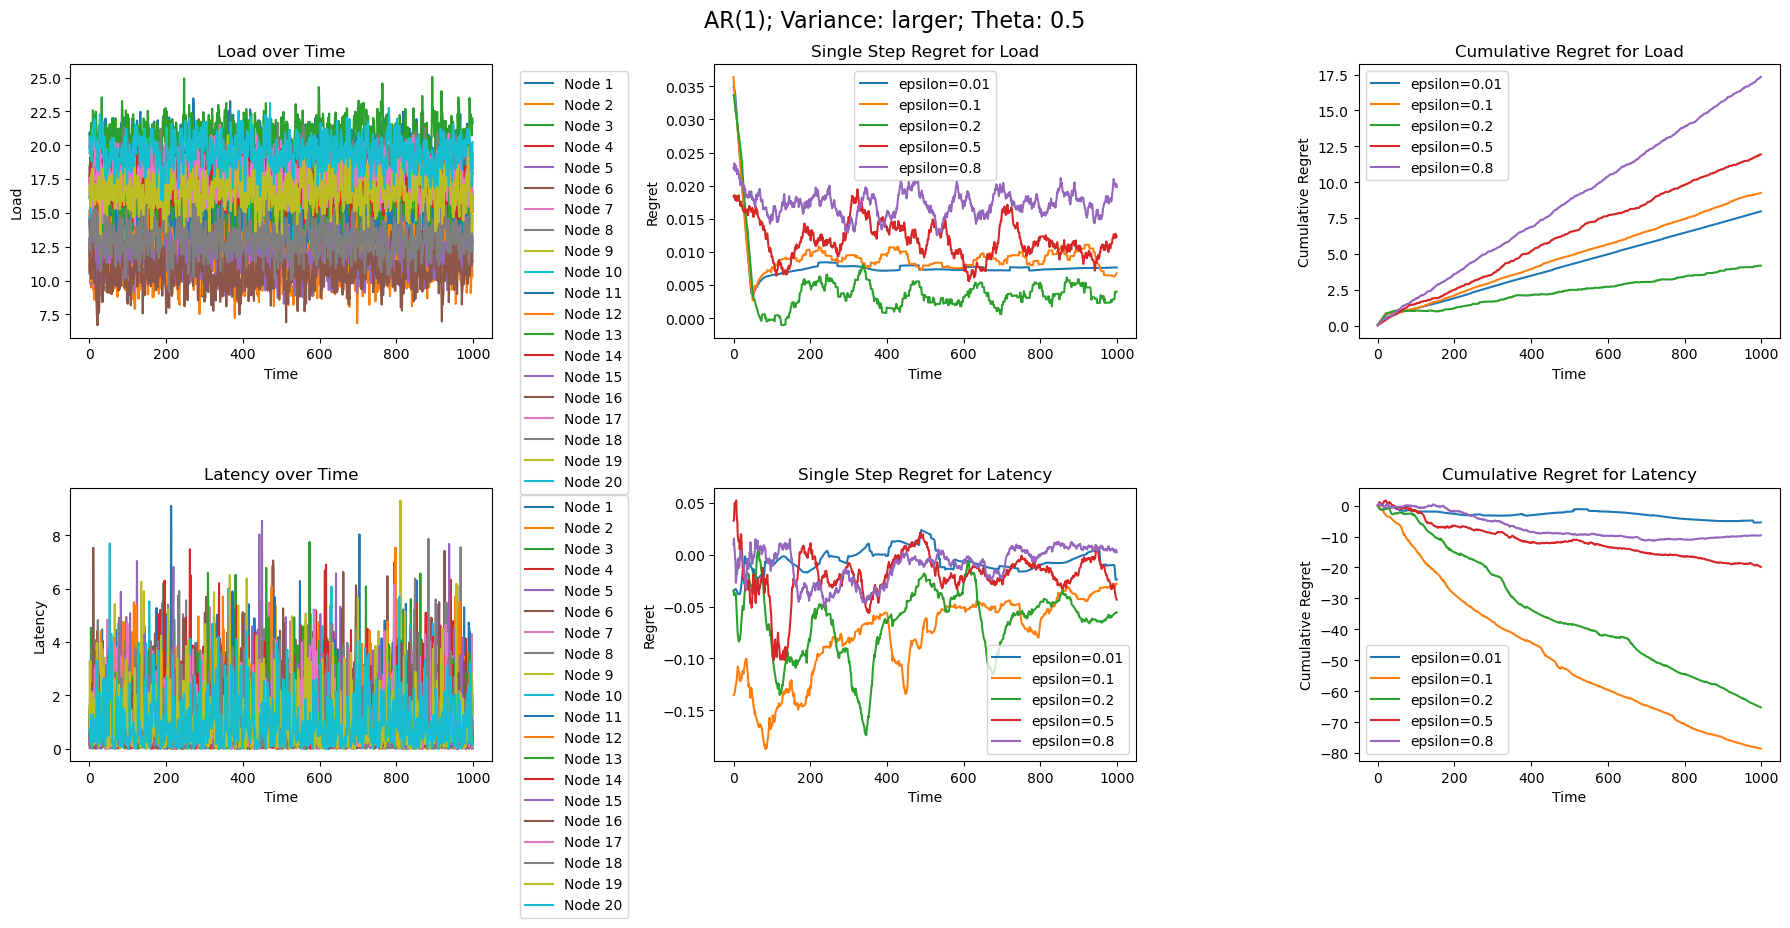

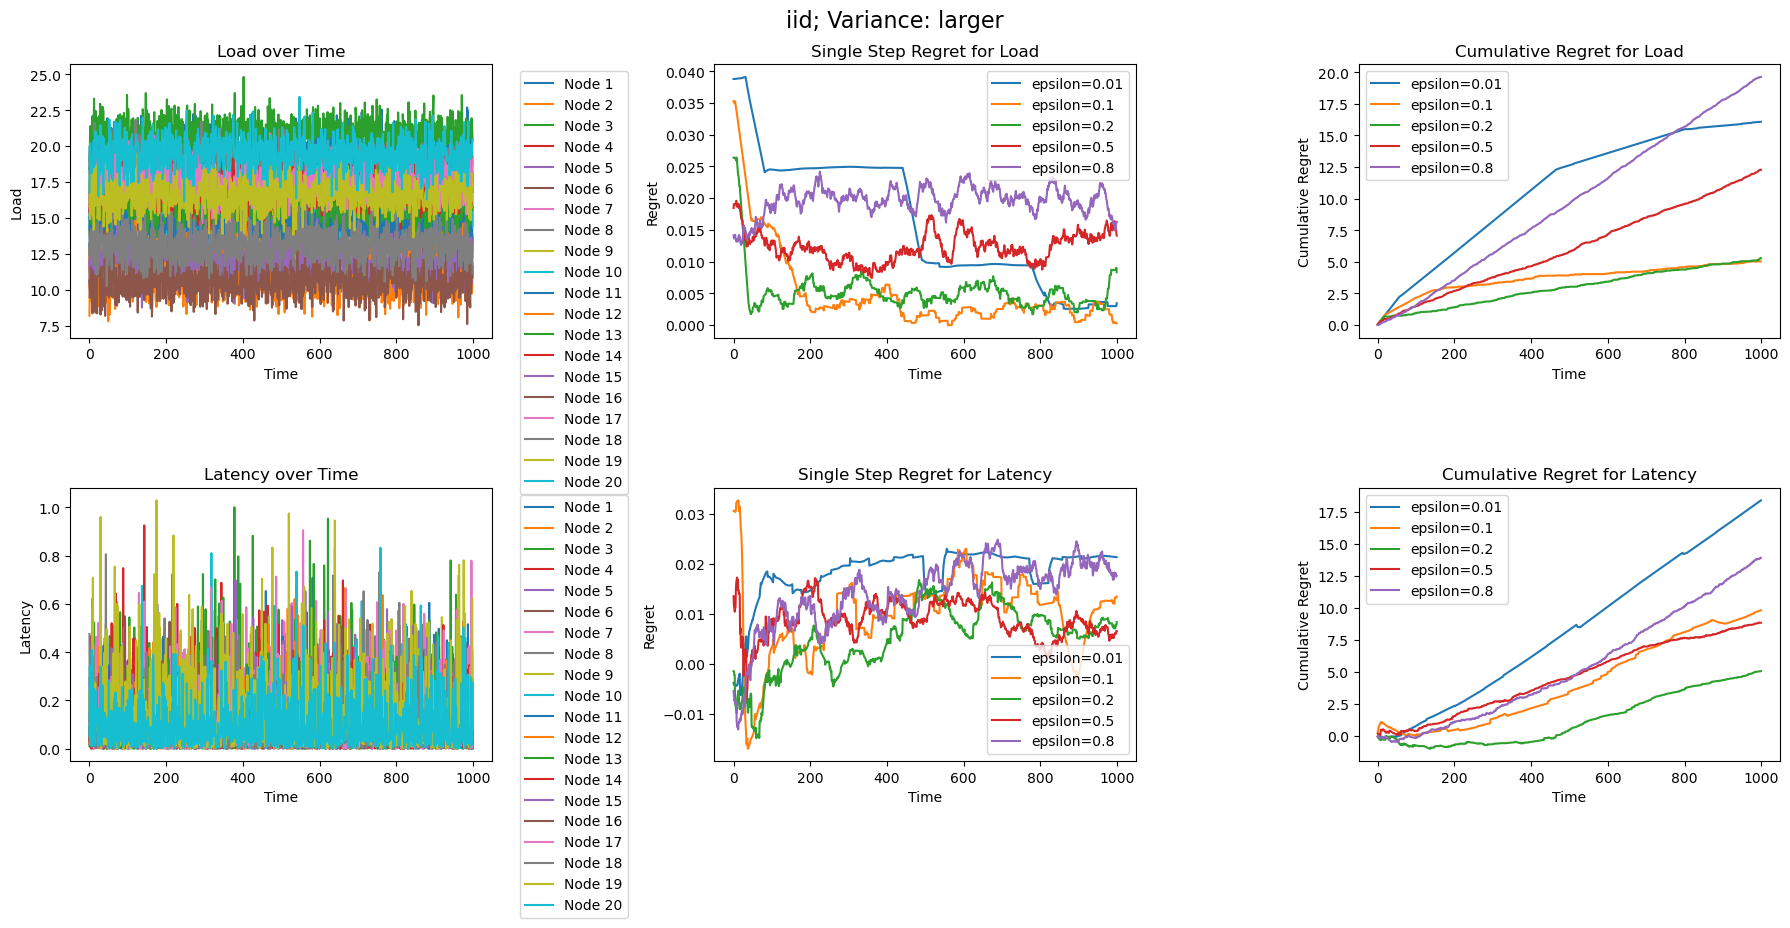

In [10]:
means_load, means_latency = generate_means(N, mean_load, var_load, mean_latency, var_latency)

load_ar1, latency_ar1 = generate_ar1_data(N, T, means_load, means_latency, theta)
results_ar1 = epsilon_greedy_algorithm(load_ar1, latency_ar1, epsilons)
plot_combined_results(load_ar1, latency_ar1, results_ar1, epsilons, 'AR(1); Variance: larger; Theta: 0.5')

load_iid, latency_iid = generate_iid_data(N, T, means_load, means_latency)
results_iid = epsilon_greedy_algorithm(load_iid, latency_iid, epsilons)
plot_combined_results(load_iid, latency_iid, results_iid, epsilons, 'iid; Variance: larger')

Mean Load: 15
Variance Load: 5
Mean Latency: 10
Variance Latency: 2


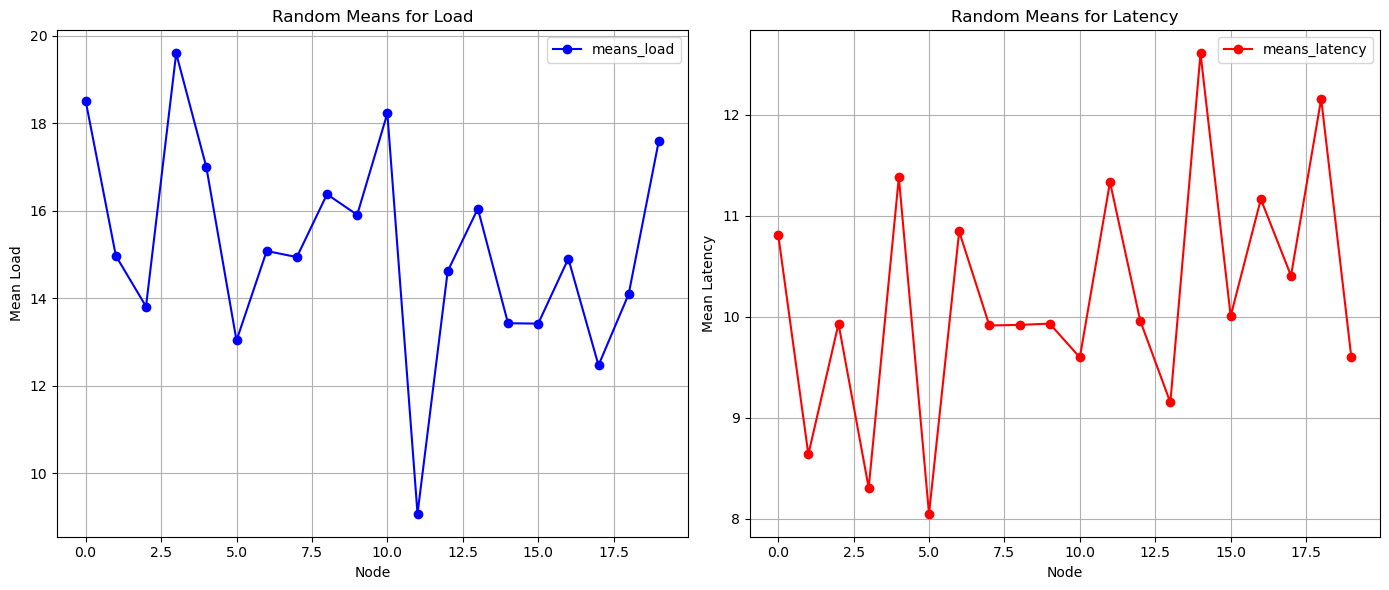

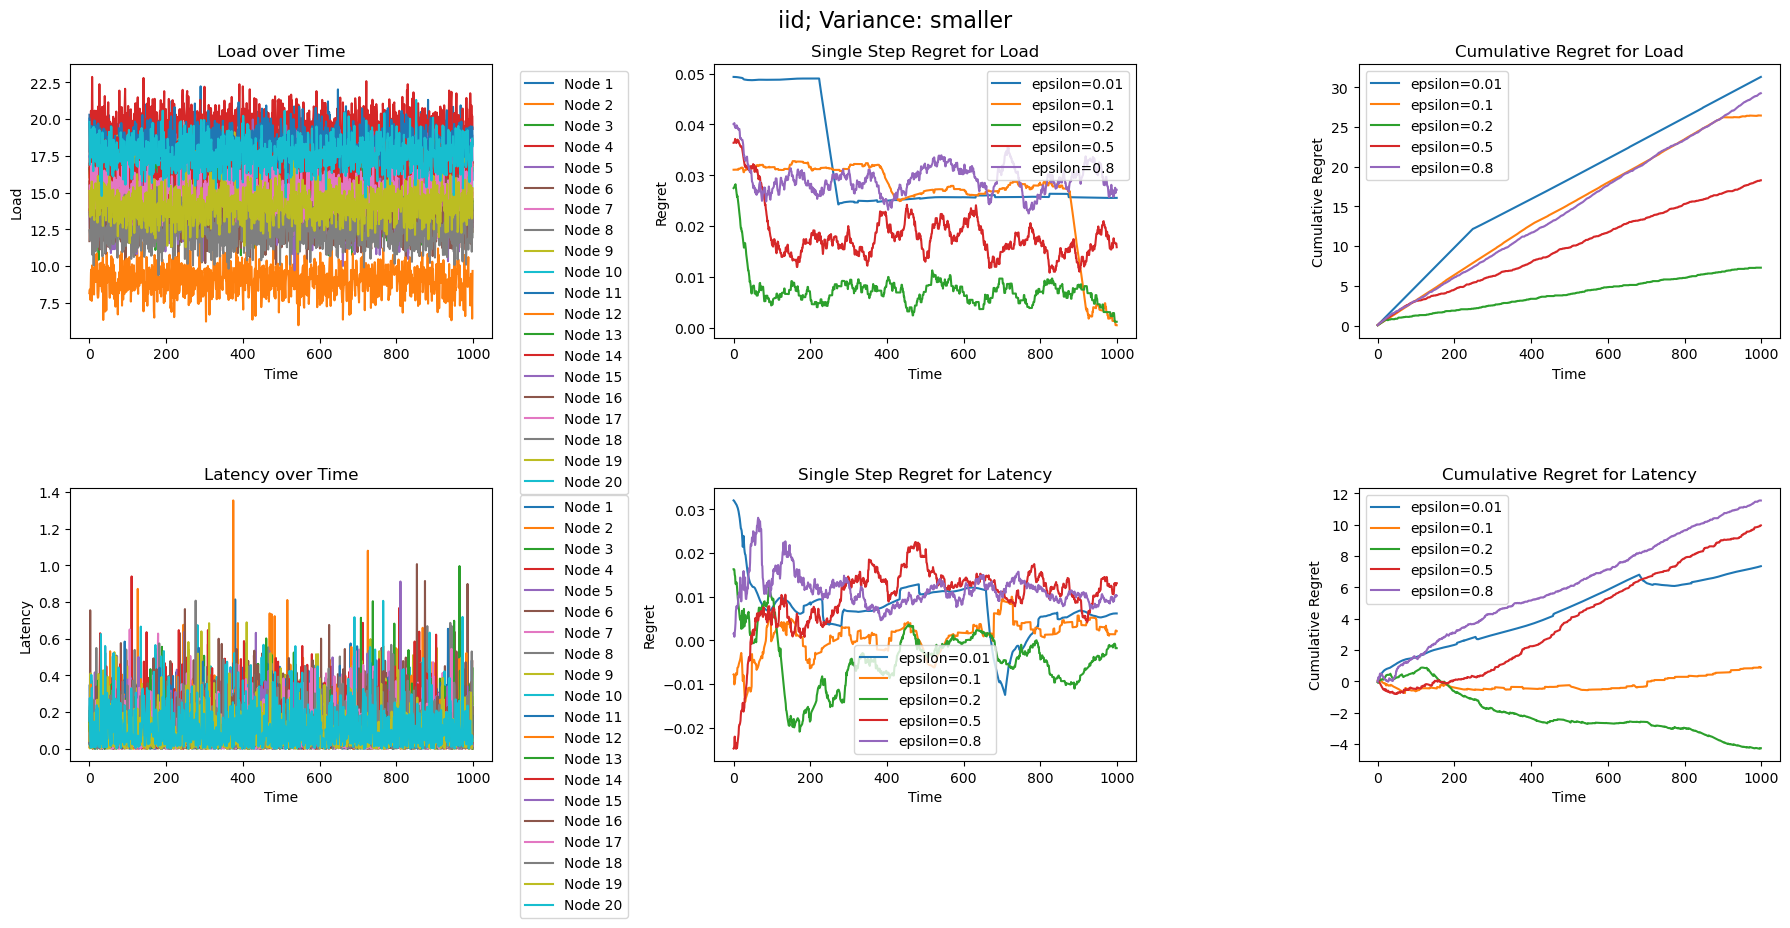

Theta: 0


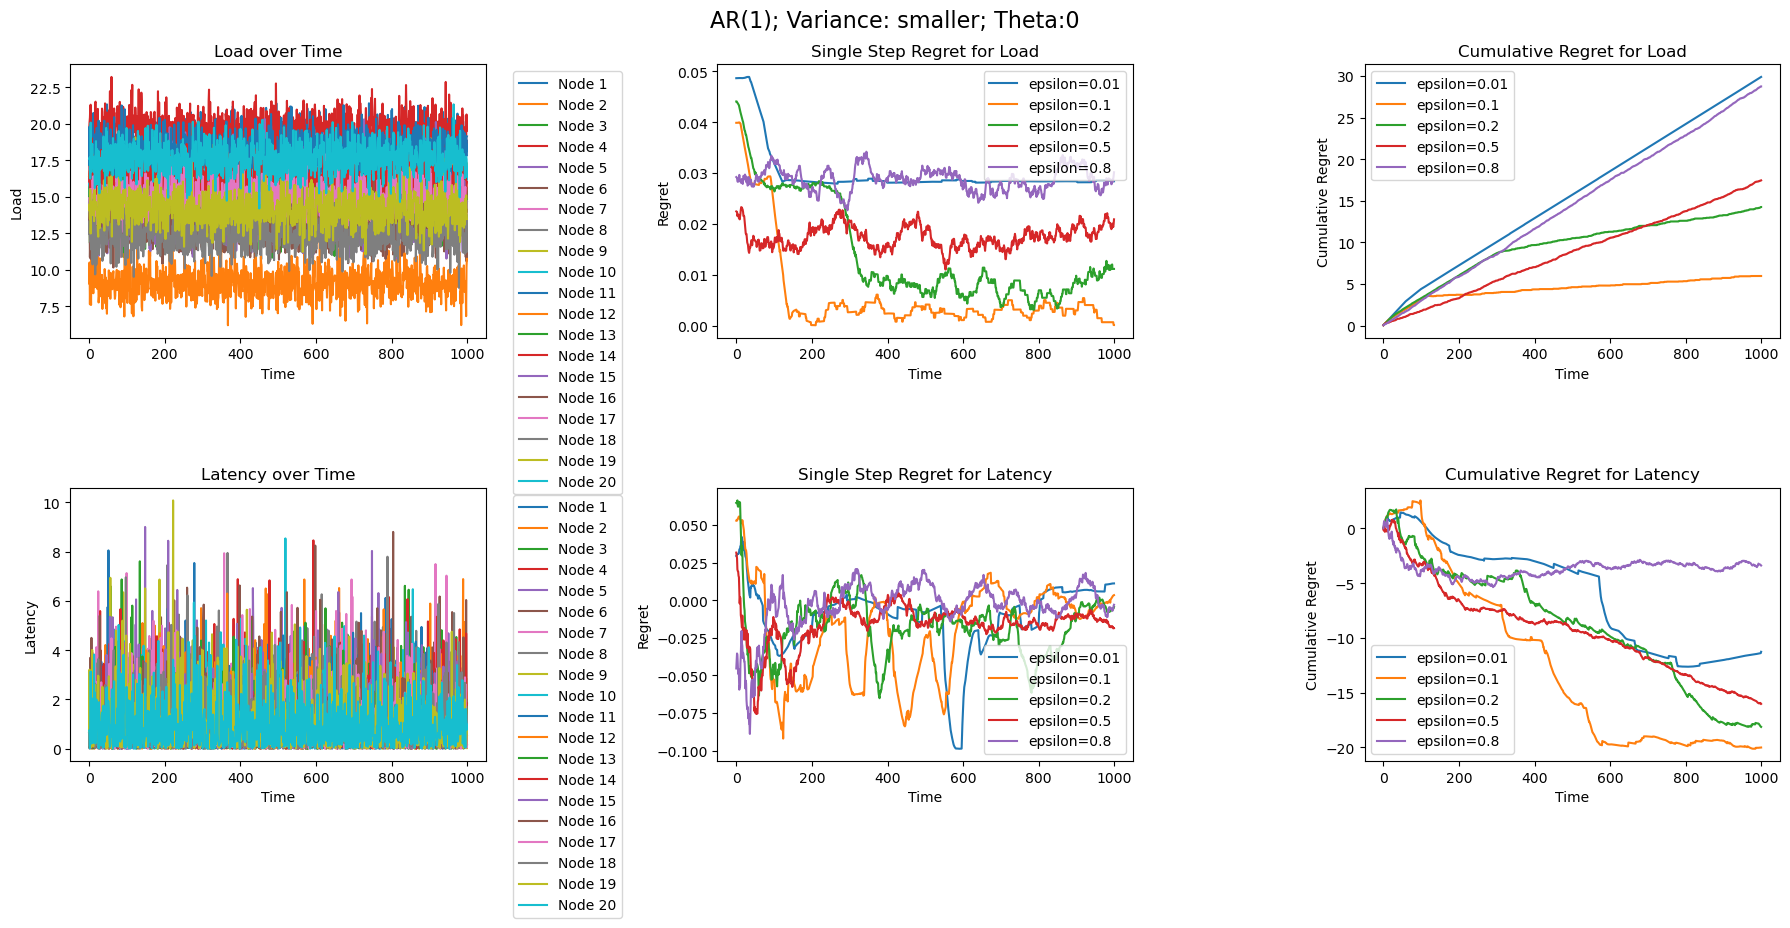

Theta: 0.2


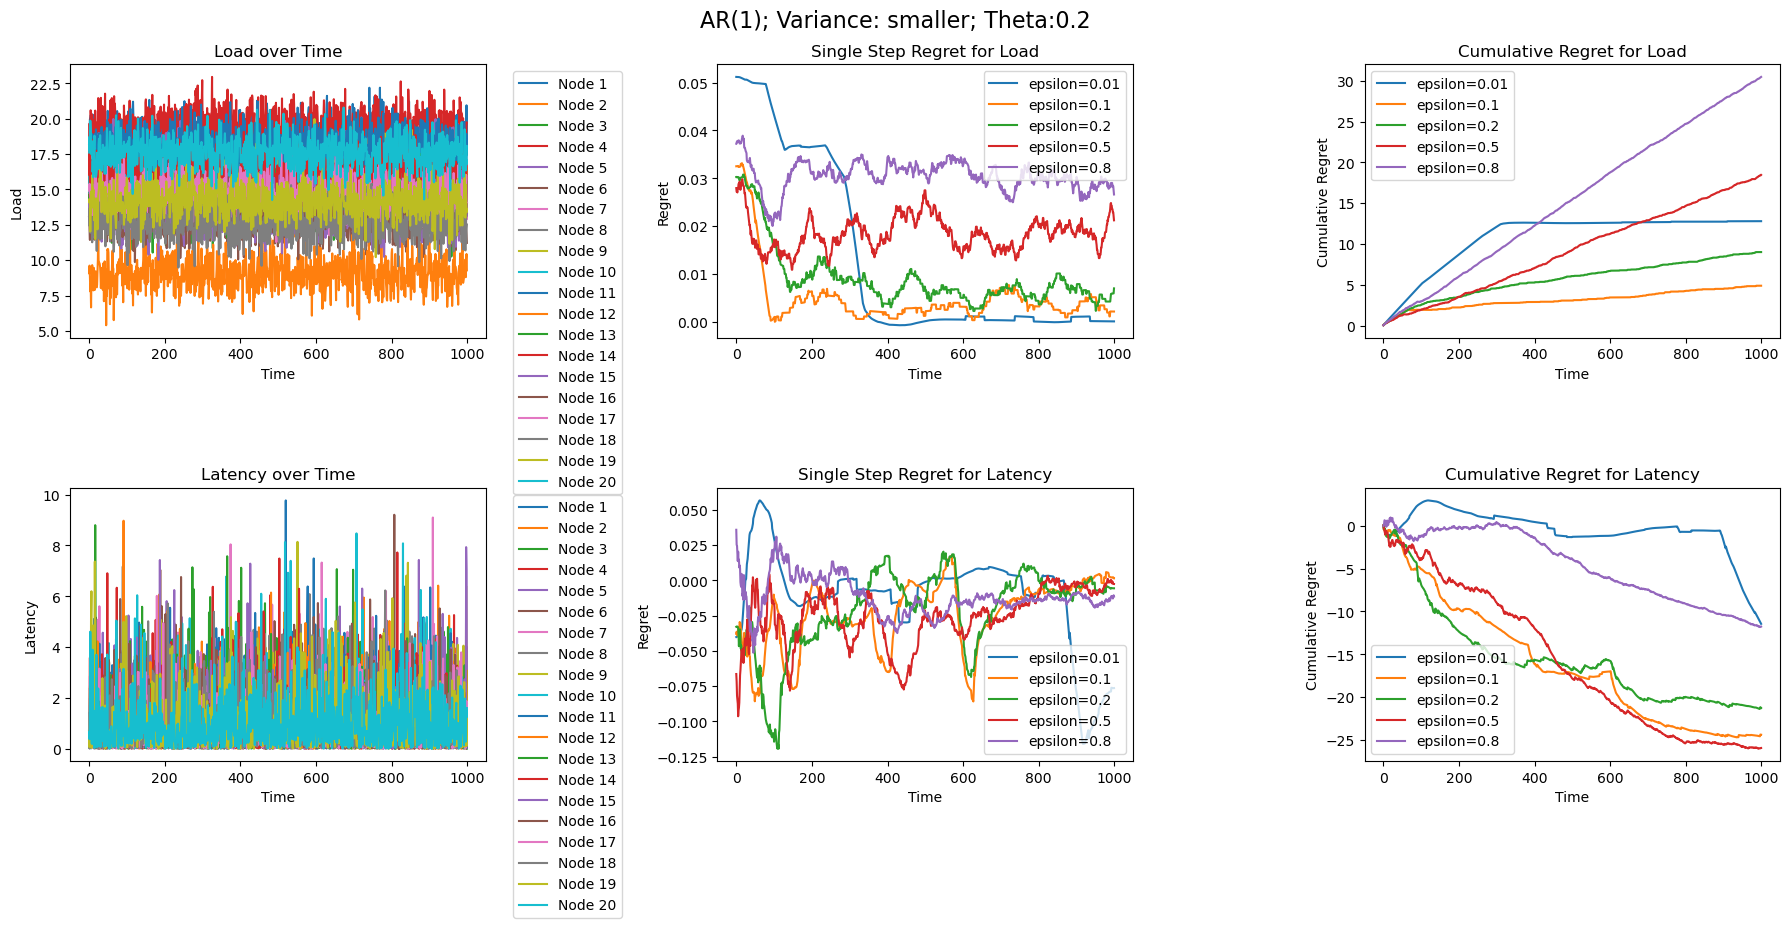

Theta: 0.5


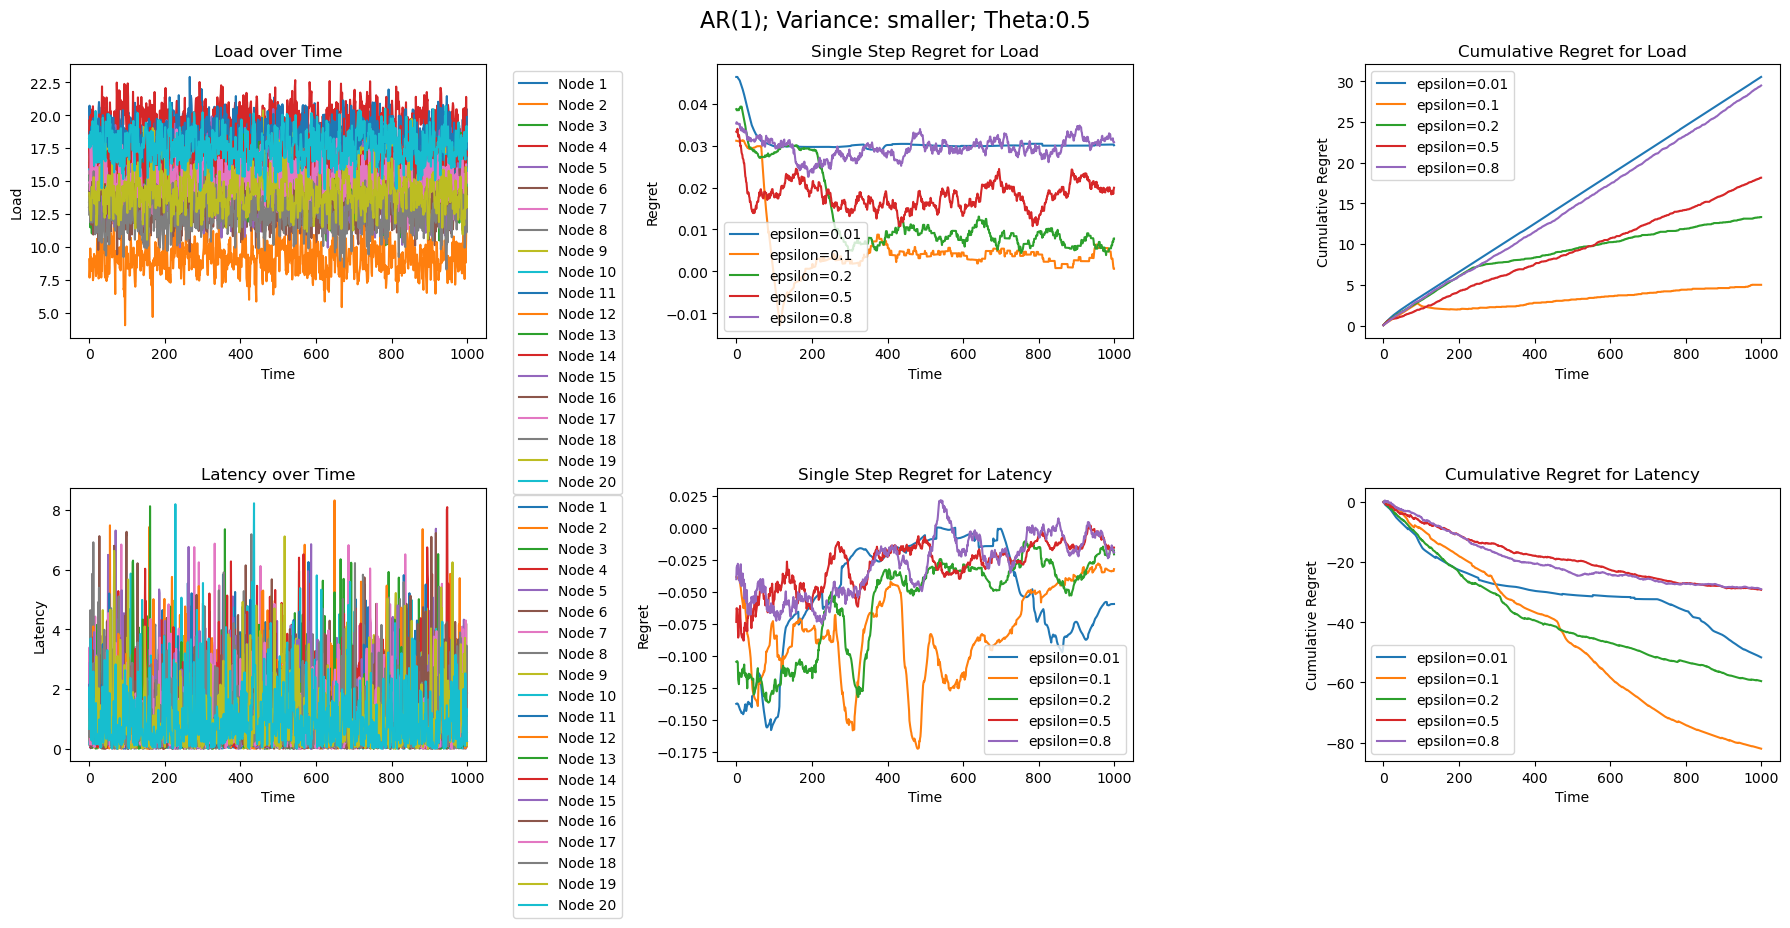

Theta: 0.8


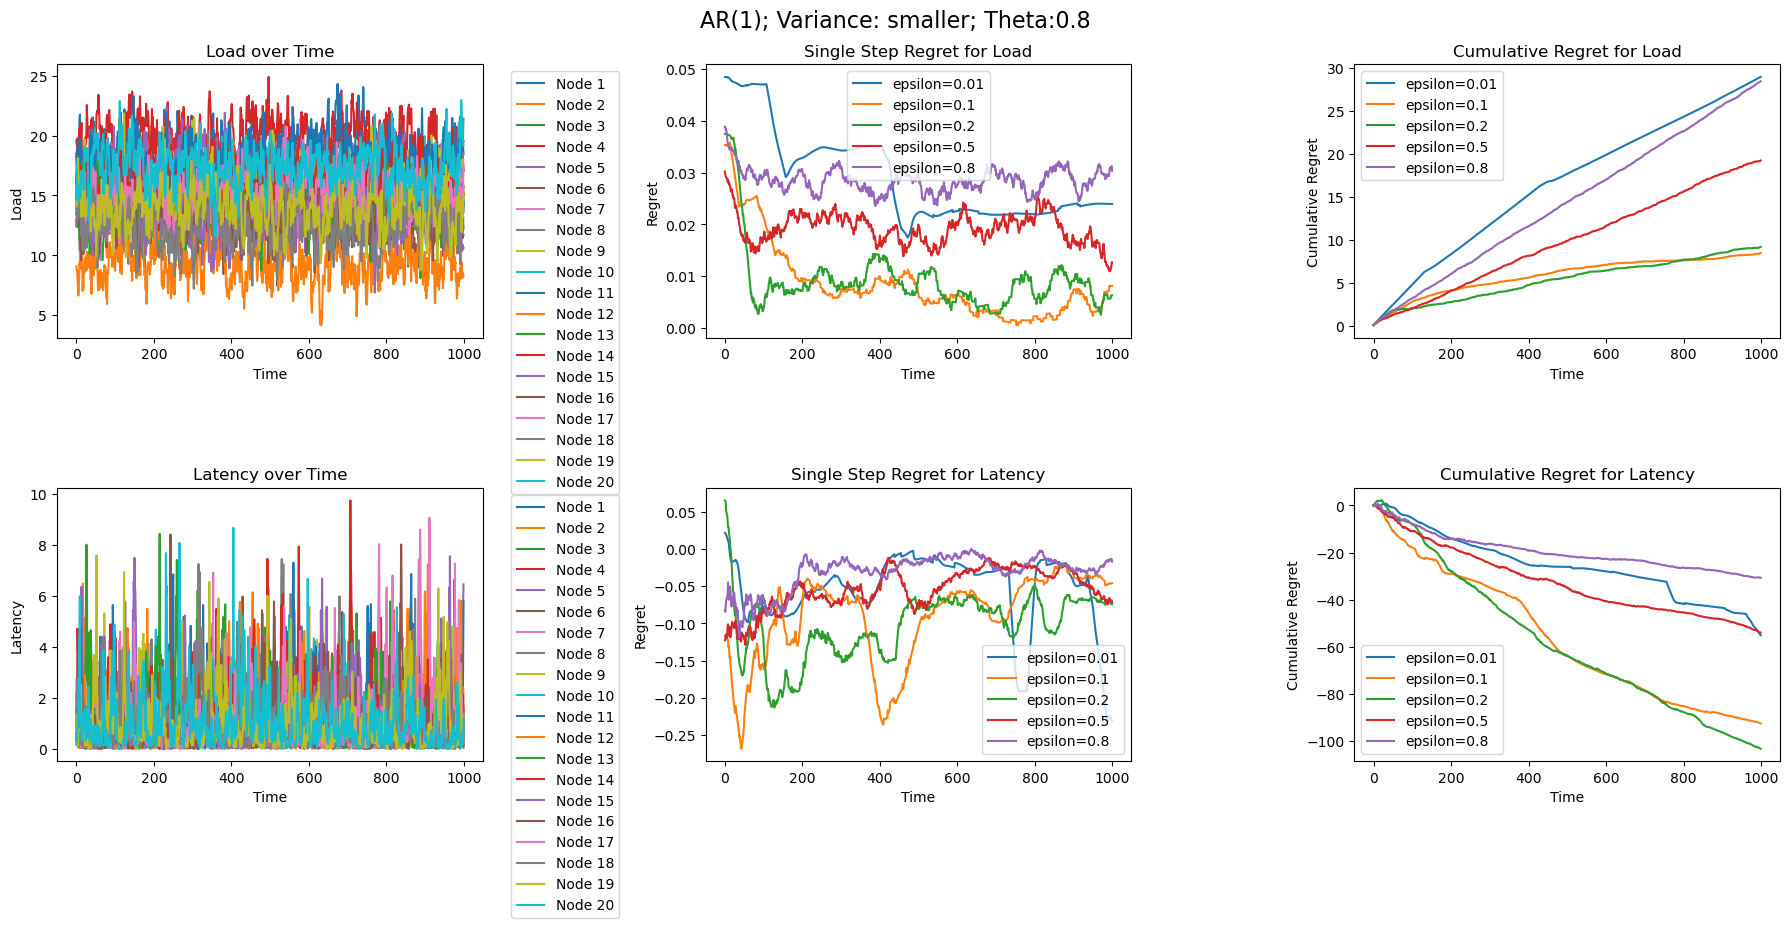

Theta: 1


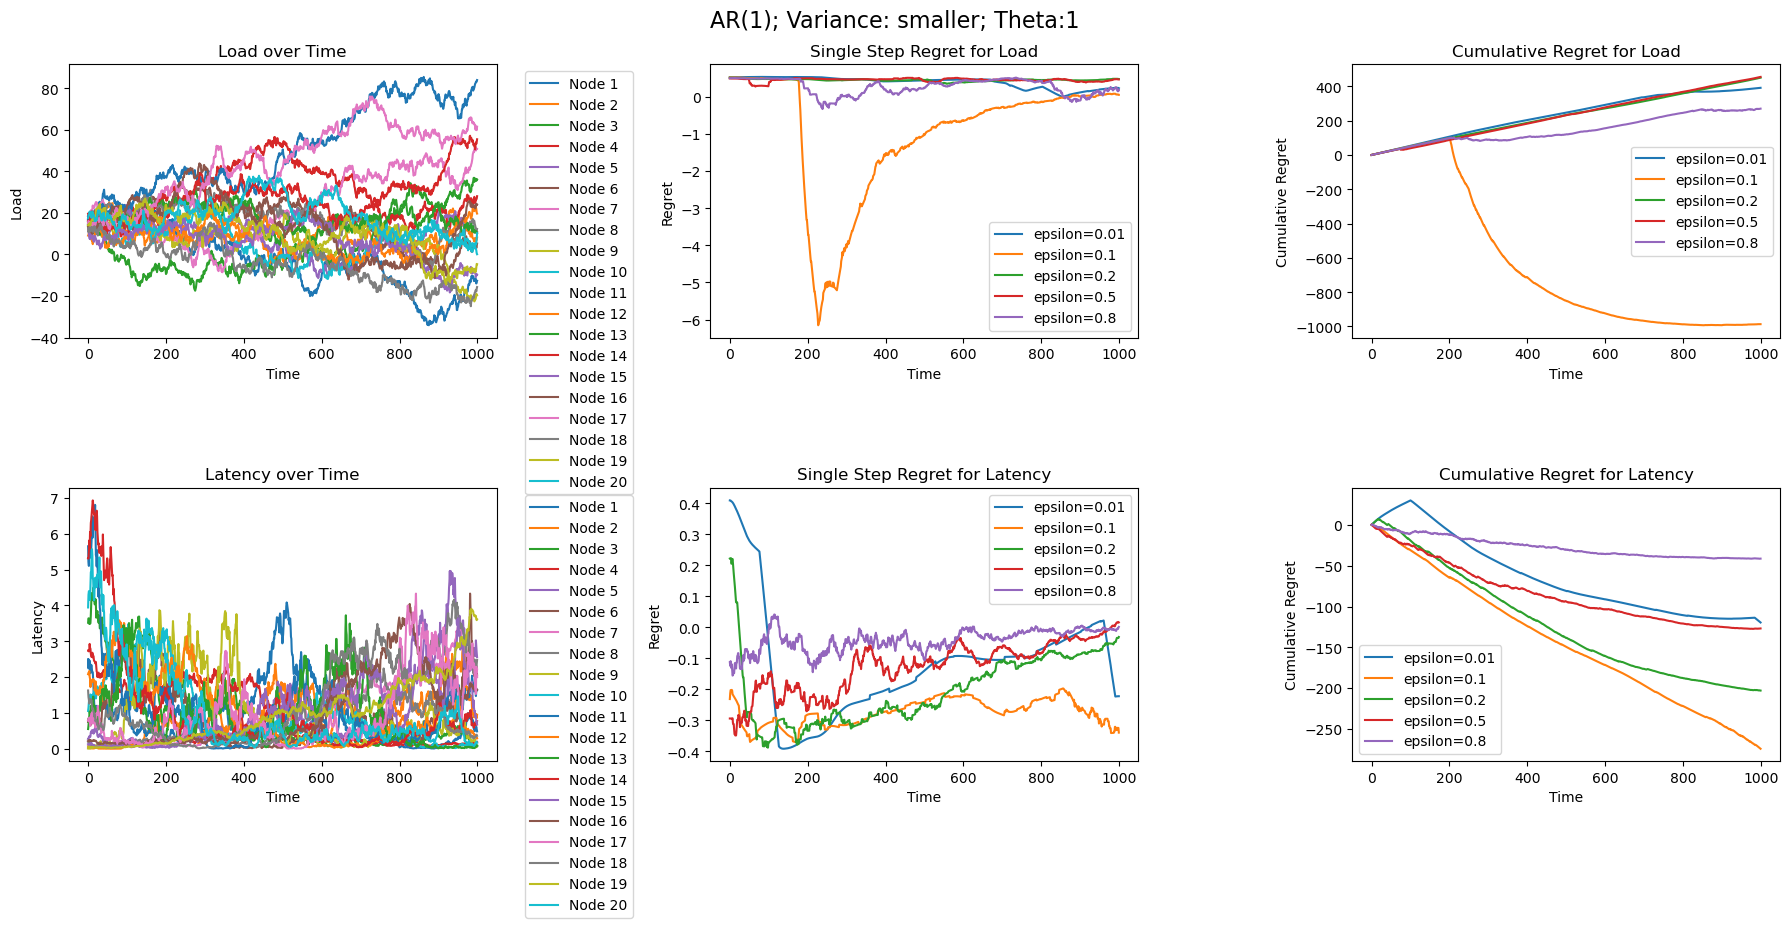

In [11]:
N = 20
T = 1000
mean_load = 15
var_load = 5
mean_latency = 10
var_latency = 2
epsilons = [0.01, 0.1, 0.2, 0.5, 0.8]

means_load, means_latency = generate_means(N, mean_load, var_load, mean_latency, var_latency)

load_iid, latency_iid = generate_iid_data(N, T, means_load, means_latency)
results_iid = epsilon_greedy_algorithm(load_iid, latency_iid, epsilons)
plot_combined_results(load_iid, latency_iid, results_iid, epsilons, 'iid; Variance: smaller')

for theta in [0, 0.2, 0.5, 0.8, 1]:
    load_ar1, latency_ar1 = generate_ar1_data(N, T, means_load, means_latency, theta)
    results_ar1 = epsilon_greedy_algorithm(load_ar1, latency_ar1, epsilons)
    plot_combined_results(load_ar1, latency_ar1, results_ar1, epsilons, f'AR(1); Variance: smaller; Theta:{theta}')